## A Correlational Study of Music Engagement and Earliest Musical Memory Vividness and Emotional Intensity

In this study we investigate the relationships between music engagement of adults and earliest musical memories. In particular, we analyzed if there is any correlation between vividness and emotional intensity of these earliest musical memories and music engagement in adult life. 
Our research question can be defined as follows:
What is the relationship between a person’s engagement with music, and the vividness and emotional intensity of their earliest musical memories?


### The Dataset

To obtain data for our research we conducted a survey with several questions relating to memory, vividness as well as demographic information. The results of our analysis of the 59 responses will be presented in this notebook. Before that, we had to preprocess the data from the survey to make it fit for further analysis. The following figure is showing a brief explanation of the filtering.

![Dataset Extraction!](data/img/mpc_methodology.jpg)

In [2]:
# Settings
import wordcloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from PIL import Image
from wordcloud import WordCloud, get_single_color_func
from matplotlib import cm
from matplotlib import colors as cls


# Load Dataset
filepath = 'data/MPC Survey Responses Filtered.xlsx'
df = pd.read_excel(filepath)

# Center plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Demographics

In this section we introduce some demographic information of the survey takers. We aimed to reach a diverse population of people with different perspectives towards music to get a balanced representation and explore possible correlations.

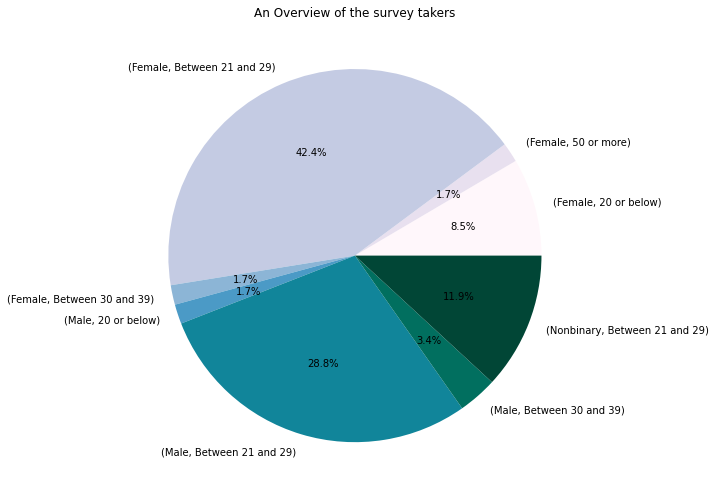

In [3]:
df.groupby(['Gender', 'Age']).size().plot(kind='pie', 
                                          figsize=(10,7), 
                                          ylabel=' ', 
                                          autopct='%1.1f%%', 
                                          title='An Overview of the survey takers',
                                          colormap='PuBuGn')

plt.tight_layout()

/Users/samuelnarvaez/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/samuelnarvaez/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


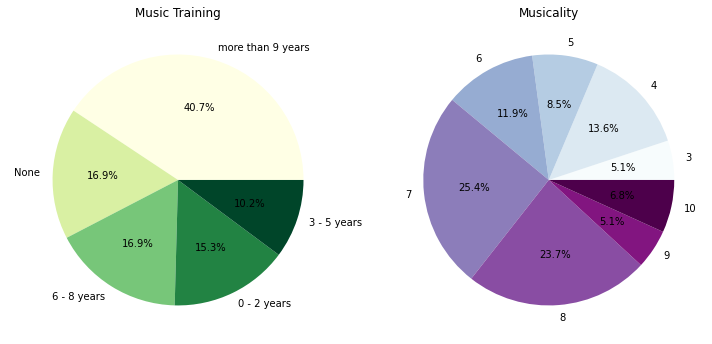

In [4]:
fig, ax = plt.subplots(1,2,figsize=(10,6))

df.MusicTraining.value_counts().plot(
                                     kind='pie',
                                     autopct='%1.1f%%',
                                     colormap='YlGn',
                                     ylabel=' ',
                                     ax=ax[0],
                                     title='Music Training')

df.MusicalityRating.value_counts().sort_index().plot(
                                     kind='pie',
                                     ylabel=' ',
                                     colormap='BuPu',
                                     ax=ax[1],
                                     autopct='%1.1f%%',
                                     title='Musicality')

plt.tight_layout()

Here we can see that almost half of the participants have more than nine years of musical training which need to be taken in consideration when making conclusions. Also we can obtain, that around half of the survey takers would rate their musicality high (7-8).

### Music Engagement

We now present the scores outcome of the musEQ questionnaire. The musEQ paper can be found [here](DOI:10.1080/13607863.2015.1021750). The original questionnaire contains 35 items for 6 categories which we shrinked down to 8 items for 6 categories to make it fit for the scope of our work. We then used the mean value for each category and obtained the musEQ score which is presented in the following figures.

/Users/samuelnarvaez/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/samuelnarvaez/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


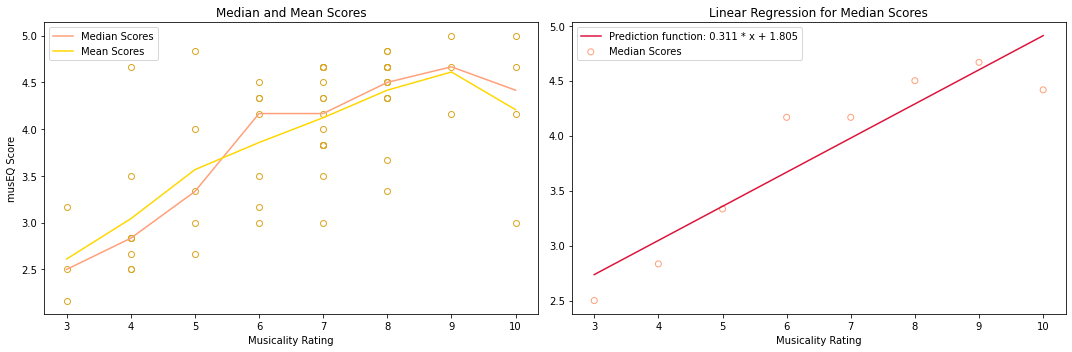

In [5]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(df.MusicalityRating, df.musEQScore, 'o', fillstyle='none', color='goldenrod')
df.groupby('MusicalityRating')['musEQScore'].median().plot(xlabel='Musicality Rating',
                                                         ylabel='musEQ Score',
                                                         label='Median Scores',
                                                         color='lightsalmon',
                                                         ax=ax[0]).legend(loc='upper left')

df.groupby('MusicalityRating')['musEQScore'].mean().plot(xlabel='Musicality Rating',
                                                         ylabel='musEQ Score',
                                                         label='Mean Scores',
                                                         color='gold',
                                                         title='Median and Mean Scores',
                                                         ax=ax[0]).legend(loc='upper left')

# Fitting a linear function to show relationship
X = np.transpose(np.array([3,4,5,6,7,8,9,10]).reshape(1,-1))
y = np.array(df.groupby('MusicalityRating')['musEQScore'].median())
lr = LinearRegression().fit(X,y)

ax[1].scatter(X, y, marker='o', facecolors='none', color='lightsalmon', label='Median Scores')
ax[1].plot(X, 
           lr.predict(X) , 
           color='crimson', 
           label='Prediction function: {coef:.3f} * x + {intercept:.3f}'
           .format(coef=lr.coef_[0], intercept=lr.intercept_))
ax[1].set_xlabel('Musicality Rating')
ax[1].legend()
ax[1].set_title('Linear Regression for Median Scores')

plt.tight_layout()

From the results we can obtain a strong relationship between the rating of the musicality and the achieved score of musical engagement. People that consider themselves as musical persons, have a higher score in the musical engagement questionnaire. Now we will investigate if there are any correlations between the vividness and emotional intensity and the musical engagement.

### Questions about your earliest musical memory

The following five questions were asked in the survey about earliest musical memories of the participants. They could rate there answers from 1 to 5. 

1. Think about the first musical or sonic experience you remember in your childhood. Try to hear it for yourself if you can. Think about the earliest situation or experience that comes to your mind that involved that song or melody.  How old were you when the episode took place?

2. To what extent does the following statement match your earliest memory of a song or melody?  -> The memory appears vivid and clear.

3. To what extent does the following statement match your earlierst memory of a song or melody? -> The episode was typical for my everyday life at that time.

4. When you recall your experience, does it then appear as a coherent episode with a beginning and an end, or is it more like one or more fragments?

5. When you recall the episode, are the emotions you experience then positive or negative?


We can categorize the five questions into:
1. Age
2. Vividness
3. Recurrence
4. Timeframe
5. Emotion

/Users/samuelnarvaez/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/samuelnarvaez/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


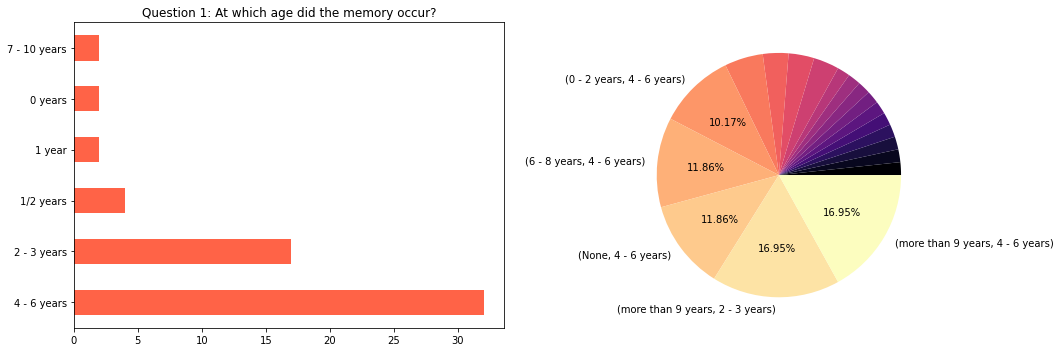

In [6]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

df.MQ1.value_counts().plot(kind='barh',
                           color='tomato',
                           ax=ax[0],
                           title='Question 1: At which age did the memory occur?')

labs = ['','','','','','','','','','','','','','',
                '(0 - 2 years, 4 - 6 years)',
                '(6 - 8 years, 4 - 6 years)',
                '(None, 4 - 6 years)',
                '(more than 9 years, 2 - 3 years)',
                '(more than 9 years, 4 - 6 years)']
df.groupby(['MusicTraining', 'MQ1']).size().sort_values().plot(kind='pie',
                                                              ax=ax[1],
                                                              legend=False,
                                                              ylabel=' ',
                                                              colormap='magma',
                                                              labels=labs,
                                                              autopct=lambda p: format(p, '.2f') + '%' if p > 8 else None)

plt.tight_layout()

From this figures we can obtain that people with longer Music Training are more likely to locate their earliest musical memory at 4-6 years of age (and from 2 years up). We might make an assumption that during this age, many children start learning an instrument and make their first musical experiences.

From this charts we can clearly see a trend in the emotionality of the memory. None of the participants scored the emotionality of the memory below 3. Further we can see that most memories seem to be only remembered as memory fragments. The vividness tends to be more positive in general as well as the recurrence of the memory.

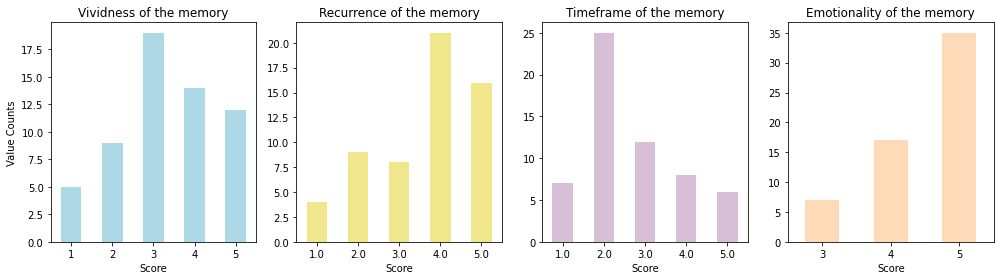

In [7]:
fig, ax = plt.subplots(1,4,figsize=(14,4))

x = np.arange(len(df.MQ2.value_counts().sort_index()))
df.MQ2.value_counts().sort_index().plot(kind='bar', 
                                        ax=ax[0],
                                        color='lightblue', 
                                        title='Vividness of the memory',
                                        ylabel='Value Counts', 
                                        rot=0, 
                                        xlabel='Score')
df.MQ3.value_counts().sort_index().plot(kind='bar', 
                                        ax=ax[1],
                                        title='Recurrence of the memory',
                                        color='khaki', 
                                        rot=0, 
                                        xlabel='Score')
df.MQ4.value_counts().sort_index().plot(kind='bar', 
                                        ax=ax[2],
                                        title='Timeframe of the memory',
                                        color='thistle', 
                                        rot=0, 
                                        xlabel='Score')
df.MQ5.value_counts().sort_index().plot(kind='bar', 
                                        ax=ax[3],
                                        title='Emotionality of the memory',
                                        color='peachpuff', 
                                        rot=0, 
                                        xlabel='Score')

plt.tight_layout()

/Users/samuelnarvaez/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/samuelnarvaez/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


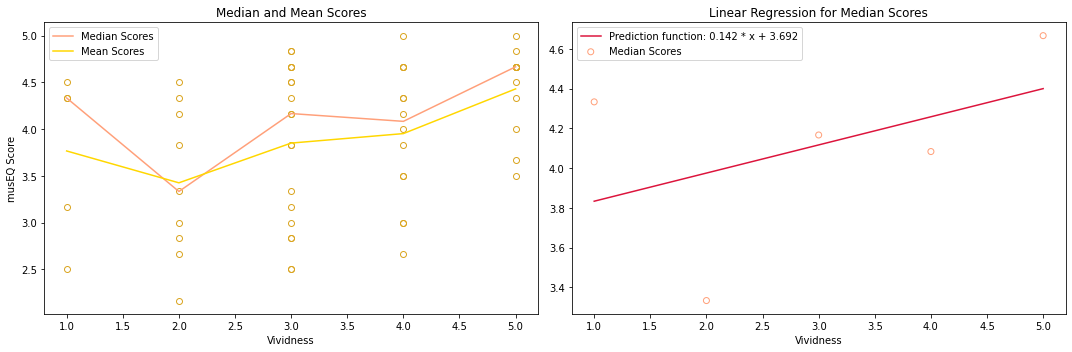

In [8]:
fig, ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(df.MQ2, df.musEQScore, 'o', fillstyle='none', color='goldenrod')
df.groupby('MQ2')['musEQScore'].median().plot(xlabel='Vividness',
                                                         ylabel='musEQ Score',
                                                         label='Median Scores',
                                                         color='lightsalmon',
                                                         ax=ax[0]).legend(loc='upper left')

df.groupby('MQ2')['musEQScore'].mean().plot(xlabel='Vividness',
                                                         ylabel='musEQ Score',
                                                         label='Mean Scores',
                                                         color='gold',
                                                         title='Median and Mean Scores',
                                                         ax=ax[0]).legend(loc='upper left')

# Fitting a linear function to show relationship
X = np.transpose(np.array([1,2,3,4,5]).reshape(1,-1))
y = np.array(df.groupby('MQ2')['musEQScore'].median())
lr = LinearRegression().fit(X,y)

ax[1].scatter(X, y, marker='o', facecolors='none', color='lightsalmon', label='Median Scores')
ax[1].plot(X, 
           lr.predict(X) , 
           color='crimson', 
           label='Prediction function: {coef:.3f} * x + {intercept:.3f}'
           .format(coef=lr.coef_[0], intercept=lr.intercept_))
ax[1].set_xlabel('Vividness')
ax[1].legend()
ax[1].set_title('Linear Regression for Median Scores')

plt.tight_layout()

As we can obtain from the plots, there is a relationship between the scored vividness of the memory and the increase of scores of the musEQ, however the function has a low increase. But this conclusion is still vage, due to the fact that we only considered one question in terms of evaluating the vividness. Therefore we presented further questions relating to memory vividness and emotional intensity to the participant to obtain scores we can evaluate more extensively.

### Vividness and Emotional Intesity

In this section we present our results on the relationship between vividness and emotional intensity of the earliest musical memory. To measure the vividness of the memory, we presented the participants with 9 questions in three categories which are standard measures of *autobiographical remembering*: 
1. Recollection (Sensory Detail)
2. Belief (Condifence)
3. Rehearsal (In/Voluntair Thinking)

Measuring of the vividness of childhood memories questions were taken from  [here](https://doi.org/10.1080/09658211.2017.1414849). The original contained 14 items within 4 categories and we shrinked it down to 9 memories in 3 categories which contain the 2 main categories and one of the auxiliary categories.

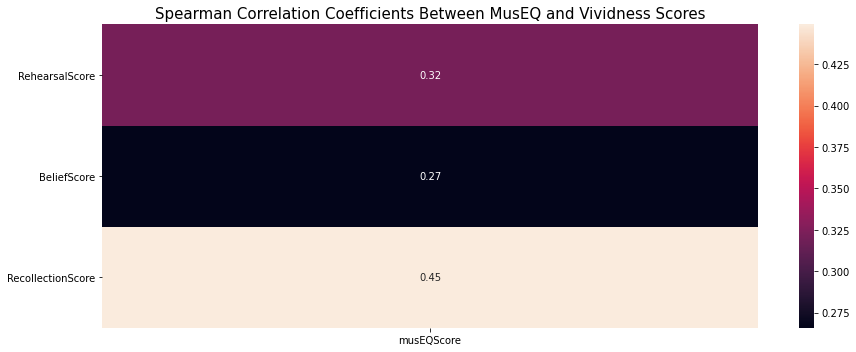

In [9]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
corr = df[['musEQScore', 'RecollectionScore', 'BeliefScore', 'RehearsalScore']].corr(method='spearman')

mask = np.array([[1.,1.,1.,1.],[0,1,1,1],[0,1,1,1],[0,1,1,1]])
sns.heatmap(corr, mask=mask, annot=True, ax=ax)
ax.set_xlim([0,1])
ax.set_ylim([1,4])
ax.set_title('Spearman Correlation Coefficients Between MusEQ and Vividness Scores', fontsize=15)

plt.tight_layout()

fig, ax = plt.subplots(1,1,figsize=(13,5))
corr = df[['musEQScore', 'RecollectionScore', 'BeliefScore', 'RehearsalScore']].corr(method='spearman')
mask = np.zeros_like(corr)
tria = np.triu_indices_from(mask)
mask[tria] = True

sns.heatmap(corr, mask=mask, annot=True)

plt.tight_layout()

### Correlation Analysis

We look for possible correlations between the *Vividness* and the *Emotional Intensity* using the measured scores. After each score is calculated we experiment with various correlation measures such as Pearson and Spearman correlation coefficients. Since the Pearson coefficient has the underlying assumption of linearity between the variables, we choose the Spearman coefficient for the analysis.

From the above plot we see that:
- scores are pairwise **positively** correlated with varying levels of non-linear correlation
- correlations could be classified as **mild**, (between 0.2 and 0.5)
- maximum non-linear correlation between **MusEQ** occurs with the **Recollection** with a *0.45* correlation coefficient.
- minimum such correlation occurs with **Belief** score with *0.27* correlation coefficient

Therefore we conclude that the Recollection score which measures the amount of the sensory detail of the earliest musical memory and the MusEQ score which measures the emotional intensity has a considerable correlation. Which can be atributed to the similarity between emotions and sensory details of memories.

### Memories

In this section we are going to have a look at the memories provided by the participants as well as investigating if people with high musical engagement tend to take the time to write down the memory they were thinking of. We will first have a look at how many people provided a memory and then taking a closer look at the details.

/Users/samuelnarvaez/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


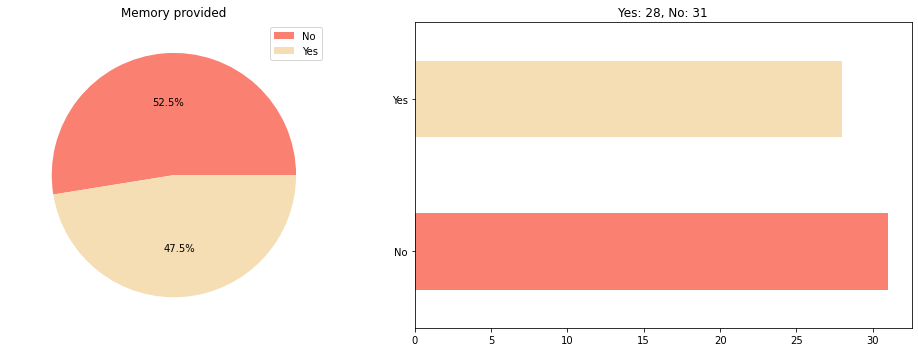

In [10]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

colors=['salmon', 'wheat']

df.MemoryProvided.value_counts().plot(kind='pie',
                                      title='Memory provided',
                                      labels=None,
                                      ax=ax[0],
                                      autopct='%1.1f%%',
                                      colors=colors,
                                      ylabel=' ').legend(loc='upper right', labels=['No', 'Yes'])

df.MemoryProvided.value_counts().set_axis(['No', 'Yes']).plot(
                                      kind='barh',
                                      ax=ax[1],
                                      color=colors,
                                      title='Yes: {yes}, No: {no}'.format(yes=df.MemoryProvided.value_counts()[1],
                                                                          no=df.MemoryProvided.value_counts()[0]))

plt.tight_layout()


In the previous figure we can see, that slightly less than half of the participants answered the optional part of providing the memory they were thinking of. Sadly, this is a bad position to make assumption from, but we still want to have a look on the relationship of the musical engagement score and the is_provided key.

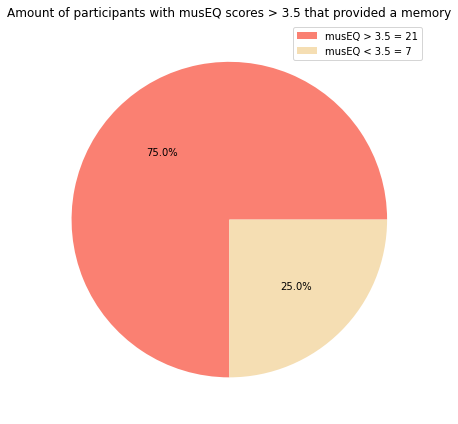

In [11]:
fig, ax = plt.subplots(1,1,figsize=(14,6))

# Calculate amount of musEQ Scores > 3.5 from the amount of people that provided memories
musEq = np.array(df.musEQScore)
is_provided = np.transpose([musEq[idx] for idx in [np.where(df.MemoryProvided == 1)]]).reshape(28,)
is_high = is_provided[is_provided > 3.5]
yes = np.ones(len(is_high))
no  = np.zeros(df.MemoryProvided.value_counts()[1] - len(is_high))

pie = pd.DataFrame(np.concatenate([yes,no]))

colors=['salmon', 'wheat']
pie.value_counts().plot(kind='pie',
                        title='Amount of participants with musEQ scores > 3.5 that provided a memory',
                        autopct='%1.1f%%',
                        labels=None,
                        ylabel=' ',
                        colors=colors
                      ).legend(loc='upper right',labels=['musEQ > 3.5 = {amount}'.format(amount=len(is_high)),
                                                        'musEQ < 3.5 = {amount}'.format(
                                                        amount=df.MemoryProvided.value_counts()[1] - len(is_high)),])

plt.tight_layout()

In the previous plot we can obtain, that from 28 people who provided a memory 75 percent (21 participants) have high musical engagement. 

#### Memories and Keywords

Finally we are going to present the open question results. We used kmeans to provide some basic text clustering and plotted the first 5 feature names for each cluster in a wordcloud below. 
The long text answers can be found in the survey excel.

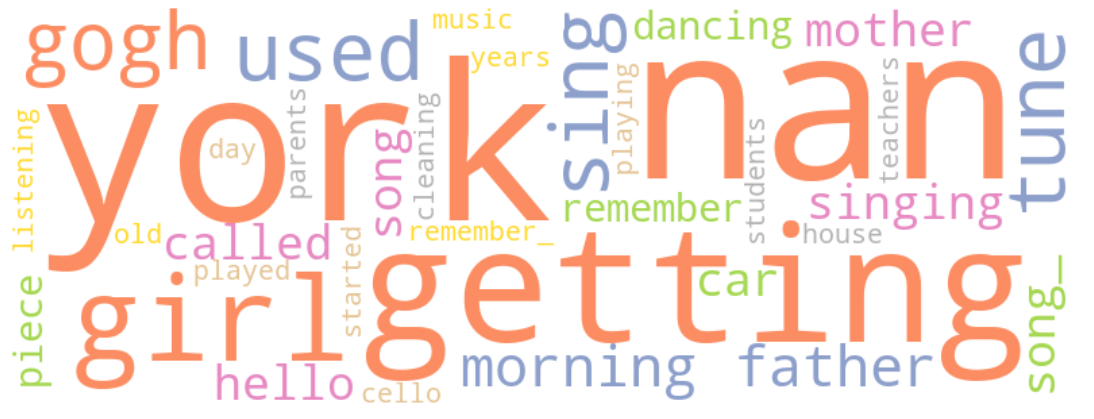

In [12]:
plt.figure(figsize=(15,6))

textfiles = df.Memories.astype('U')
vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(textfiles)

k = 8
kmeans = KMeans(n_clusters=k, max_iter=100, init='k-means++', n_init=1, random_state=10)
kmeans.fit(features)

df['clusters'] = kmeans.labels_

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

cmap = cm.get_cmap('Set2', 8)    # PiYG

clrs = []
for i in range(cmap.N):
    rgba = cmap(i)
    clrs.append(cls.rgb2hex(rgba))

### Code from wordcloud doc -----
class SimpleGroupedColorFunc(object):
    def __init__(self, color_to_words):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word)
### ----

color_to_words = {}
keywords = []
for i in range(k):
    temp = []
    if(i == 0):
        continue
    for j in order_centroids[i,:5]:
        if not (terms[j] in keywords):
            temp.append(terms[j])
            keywords.append(terms[j])
        else:
            temp.append(terms[j] + '_')
            keywords.append(terms[j] + '_')
    color_to_words.update({clrs[i] : temp})
    
keywords = np.array(keywords)

strings = (" ").join(keywords)
wc = WordCloud(collocations=True, width=800, height=300, background_color='white').generate(strings)
color_func = SimpleGroupedColorFunc(color_to_words)
wc.recolor(color_func=color_func)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')

plt.tight_layout(pad=0)

Here we are plotting the first 5 feature names of the eight clusters of the text answers. As we can see, the categories contain mostly keywords associated with positive memories of childhood, family and musical instruments which emphasize our findings from above on mostly positive ratings for the memories. In the following section we provided some of the memories to just have a basic overview of what the participants answered (with the respective color to compare with the keywords).

In [13]:
from IPython.display import display, Markdown

s = ''
for idx, sent in enumerate(df.Memories):
    if str(sent) == 'nan':
        continue
    c = clrs[kmeans.labels_[idx]]
    display(Markdown("<font color='" + c + "'>'" + sent + "</font>"))


<font color='#a6d854'>'I was five years old, and I remember very clearly staying at my big sister's bedroom, in a very specific corner of the room. I was trying to memorize the lyrics of a song which I really liked as a child. The song was "Dime", the first single of an ex-participant of a famous Spanish TV music reality show ("Operación Triunfo"), called Beth. I was clearly excited about this singer, possibly because we share a similar name. As I remember, I was at this particular place in my sister's bedroom next to a music stereo system and in front of a window, and I was playing that song and stopping at every end of line in order to write it down in a piece of paper. I also remember one of my sisters, I think the oldest, standing next to me and correcting and guiding me while I was writing the lyrics. I repeated each line several times to memorize it, I was very happy and clearly excited to do this exercise, humming the song as I listened and wrote the lyrics.</font>

<font color='#ffd92f'>'My great uncle came for a visit. He sat at the piano and played jazz or ragtime music. It was fun and completely different and I remember being amazed at how easily his fingers flew across the keys to make beautiful sounds. I must have been about 3 years old</font>

<font color='#ffd92f'>'My first concert - James Taylor at an outdoor venue at nighttime in the summer. I was maybe 2 years old and was sitting on my dad’s shoulders. I remember his face being shadowed on stage, and the moon was big and bright. The song was “Carolina in my Mind”. </font>

<font color='#e78ac3'>'Singing a very specific hello song with my mother </font>

<font color='#8da0cb'>'I remember my father used to sing a tune which he made up his own when serving the dinner or lunch. The whole family was happy and we laugh at that tune. </font>

<font color='#e5c494'>'My mother is a cellist and every single day she practices and plays bach cello suite to warm up. I have such a distinct memory of the tune but she played it so often that the event of me hearing it as a child is very jumbled because she played it around me every day for the first few years of my life. </font>

<font color='#66c2a5'>'My Blues Clues Solar System toy that sang about all the planets! I would play with it all the time. Well the sun's a hot staaarrrr 🎶</font>

<font color='#ffd92f'>'My dad used to always blast music while he was cooking dinner. I remember him listening to mobey a lol lol. </font>

<font color='#b3b3b3'>'We held a short dance performance in kindergarten for our parents. There were lots of parents, teachers, and students. All of us students had matching outfits and one of the teachers helped lead the choreography. </font>

<font color='#8da0cb'>'My mom used to sing me a Hebrew song to help me go to sleep when I was little and would tuck my hair behind my ear </font>

<font color='#ffd92f'>'Hey Sam, it’s me Arturo Manzo. Cool work with this survey, hope you get a collective amount. The memory I was thinking about was Christmas music on Christmas Day, most emotional experience to remembering; with all the anxiety in the world to see if I was getting gifts from “Santa. But because my parents never stopped listening to the same song over and over, ‘Feliz Navidad’ haha. Cheers buddy :D</font>

<font color='#b3b3b3'>'I always remember my parents cleaning the house to brown eyed girl </font>

<font color='#e5c494'>'My first musical memory is practicing the cello with my mom. I had just started playing and my parents were still looking for a cello for my size, so the first couple months of playing were on a wooden facsimile my dad made. The strings were drawn on so I had to sing everything I “played”. This particular memory is of my mother directing me through my practicing and me singing her a song I made up while playing. She would always let me do this at the end of each practice session together growing up.</font>

<font color='#a6d854'>'I loved ballet as a kid and would have my mom turn on music for me to dance to in our living room. I remember such occasion wearing a yellow dress and dancing to the same classic piece over and over </font>

<font color='#e78ac3'>'my mother in her rocking chair, singing to me as i’m about to fall asleep in a dark room with light coming in from the hallway, “all my loving” by the beatles </font>

<font color='#b3b3b3'>'My mom was really into the clubbing scene in New York during the late 80s and 90s and was really into like house music which she played all the time around the house when we were cleaning. House music is cool asf </font>

<font color='#66c2a5'>'A Christmas roadtrip to Granada with my parents when I was around 3. My father was driving while my mother was searching for the right road on a map. We were listening to La Oreja de Van Gogh’s CD “Lo que te conté mientras te hacías la dormida”. </font>

<font color='#66c2a5'>'Se trata de una nana que mi madre solía cantarme, la tenía medio en el inconsciente hasta que nació mi sobrina y se la cantó. Tan pronto como empezó me vino toda la letra y melodía a la cabeza y eso que llevaba 20 años sin escucharla.</font>

<font color='#e5c494'>'I remember watching my sister playing the piano. That day she started showing me how to play a little bit for the first time.</font>

<font color='#e78ac3'>'My grandma singing me a song called “Chalaneru” in order to make me sleepy </font>

<font color='#66c2a5'>'La nana que me cantaba mi madre para dormir </font>

<font color='#ffd92f'>'There was a Disney songs  casette in my home. I remember playing "Colors in the wind", from Pocahontas on repeat, when i was little.</font>

<font color='#e78ac3'>'Its a memory of my dad singing to me a french song called Alouette, although he doesnt speak any french I loved the weird but calming sounds he produced while singing, I remember laughing and trying to imitate de words. Even now I have no idea what the song is about. </font>

<font color='#a6d854'>'I remember every time I was on my father's car, the first song playing on the CD player was You never can tell by Chuck Berry, and as soon as I entered the car I would start dancing to that song.</font>

<font color='#8da0cb'>'Lullaby songs: two that my father created por me and my sister and onw that my mother used to sing in the morning as she opened our window. She still sings that song whenever se calls us in the morning.</font>

<font color='#ffd92f'>'I remember listening to Tears In Heaven during an English class at school when I was about 9 years old. With the teacher we were listening to the song and trying to understand what it meant, translating it to Spanish. I also remember singing it at home after that lesson and thinking I wanted to be a singer when I grew up</font>

<font color='#66c2a5'>'i was in kindergarden and a music teacher introduced the concept of "do re mi fa sol la si" to me.</font>

<font color='#ffd92f'>'My early music school graduation (8 years old)</font>

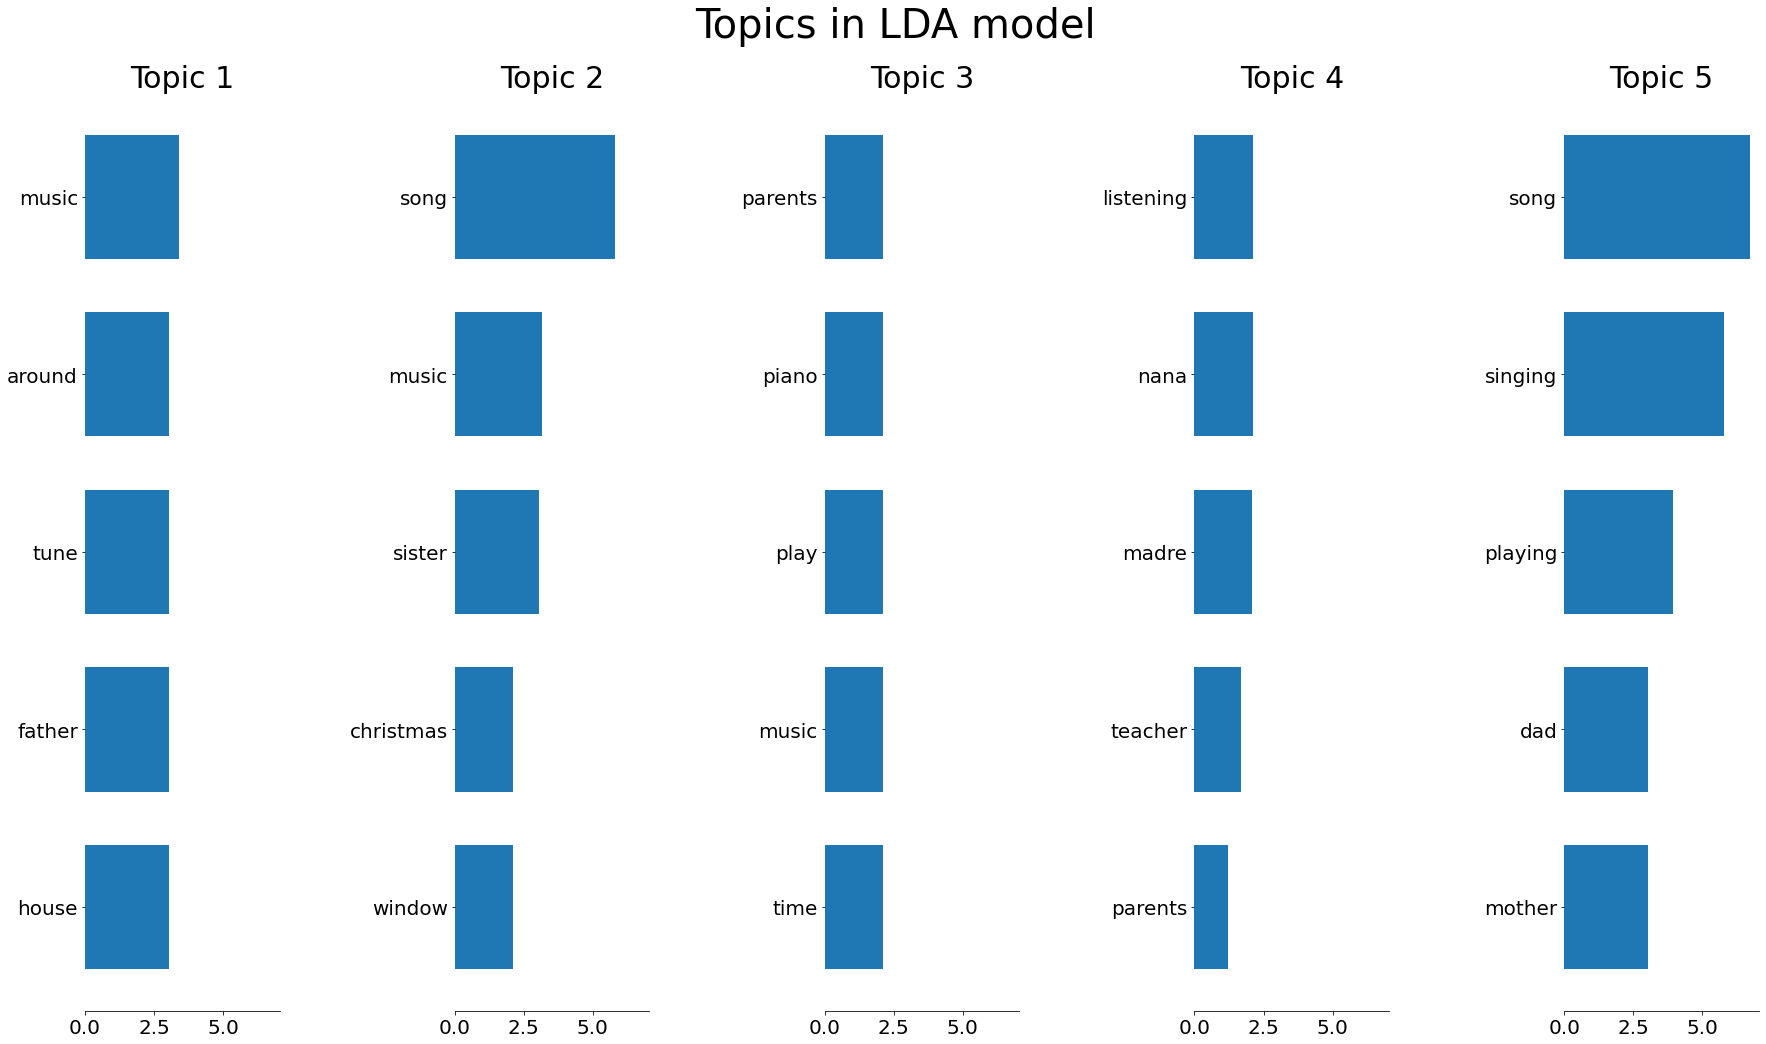

In [18]:
nltk.download('stopwords', quiet=True)

stopword_en = nltk.corpus.stopwords.words('english')
stopword_es = nltk.corpus.stopwords.words('spanish')
stopword = stopword_en + stopword_es + ['remember','made','first','would','used','years','old','every','order']

mems = df.Memories.dropna()

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=1000, stop_words=stopword 
)

tf = tf_vectorizer.fit_transform(mems)

lda = LatentDirichletAllocation(
    n_components=5,
    max_iter=50,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, 5, "Topics in LDA model")


These generated topics give us a rough sense of the most common contexts and ways of describing the memories provided in the survey. More work could be done to properly stem the words so that "play" is considered equivalent to "playing", for example. This is difficult because the text responses included both english and spanish, which gramatically have different methods of stemming words. 

Either way, these five topics show us that these memories are strongly associated with home, parents or other elders, and holidays. 